In [2]:
''' (d)【代码题】请用至少一种其它网络模块来搭建网络，并和 MLP 网络对比优缺点。'''
import torch 
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
device = 'cuda:0' if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
filepath = "train.csv"
train_data = pd.read_csv(filepath)
test_data = pd.read_csv("test.csv")

In [4]:
'''将train.csv and test.csv 中的数据转化为np.array，按照原格式81*735一行一行的存入数组中'''
def loaddata(data, rows, lines):#将每一行的各列的数据放入train_data_row中
    data_rows=[]
    for row in range(0,rows):
        data_row=[]
        for line in range(0,lines):
            data_row.append(data[str(line)][row]) #将每一行的各列的数据放入train_data_row中
        data_rows.append(data_row)
    return np.array(data_rows)

In [5]:
def normalizationdata(data):  #归一化
    range = np.max(data) - np.min(data)
    return (data - np.min(data)) / range

In [6]:
'''将训练数据和测试数据的每一行都装入train_data_rows'''
train_data_rows = loaddata(train_data, 81, 735)  #有81行数据
#print(train_data_rows[0])
test_data_rows = loaddata(test_data, 81, 56)
type(test_data_rows)

numpy.ndarray

In [7]:
'''将数据归一化处理'''
train_data_rows_nor = normalizationdata(train_data_rows)
test_data_rows_nor = normalizationdata(test_data_rows)
#test_data_rows_nor[0]

In [8]:
'''设置输入步长为679，输出步长为56的情况训练，
获取训练数据的输入和要和输出进行对比的标签
training_data_pred为标签（即后56个值）
training_data_feature为特征（即输入的679个值）'''
training_data = torch.from_numpy(train_data_rows_nor)
print("原始数据大小"+str(training_data.shape))

training_data_feature = training_data[:,[range(679)]]
#取training_data每行中的前679个训练数据,刚好能剩下56个做输出预测
training_data_feature = training_data_feature.squeeze()
#去除值为1的维度

training_data_pred = training_data[:,[range(679,735)]]
training_data_pred = training_data_pred.squeeze()

print("训练集中的输入数据大小:"+str(training_data_feature.shape))#输入的特征
print("训练集中作为标签的数据大小:"+str(training_data_pred.shape))#输出要进行比较的标签形状

原始数据大小torch.Size([81, 735])
训练集中的输入数据大小:torch.Size([81, 679])
训练集中作为标签的数据大小:torch.Size([81, 56])


In [9]:
'''建立LSTM模型'''
class RNN(nn.Module):
    def __init__(self, input_size = 679):
        super(RNN,self).__init__()
        self.input_size = input_size

        self.lstm = nn.LSTM(input_size,8,2) #输入数据input_size个特征维度，8个隐藏层维度，2个LSTM串联，第二个LSTM接收第一个的计算结果
#两个特征维度表示输入序列中的inpuge_size个数字进模型，8个隐藏层维度说明输出为8个值，2个LSTM串联表示两个LSTM堆叠起来，上一个LSTM输出的值输入到下一个LSTM中 

        self.linear = nn.Linear(8,56) #线性拟合，接收数据的维度为32，输出数据的维度为56
#线性层，即多层感知机那样的层，将LSTM6个隐藏层的输出值输入到线性层中，然后输出输出步长个值，如果要对未来56天的数据进行预测，则应该为(32,56)

    def forward(self,x):
        x1,_ = self.lstm(x)
        #https://zhuanlan.zhihu.com/p/39191116
        #lstm的输出有两个，output和(hn,cn)
        #output是最后一层lstm隐藏层的输出
        # hn,cn是所有层最后一个隐藏元和记忆元的输出
        a,b,c = x1.shape
        out = self.linear(x1.view(-1,c))
        #将lstm输出的输出步长(56)个值输入到线性层中

        #view(-1,c)函数将其自动调整为x1.shape[0]*c = 初始的所有元素个数
        out1 = out.view(a,b,-1)
        #线性层的输出调整为有多少个数据以及batch，最后一个维度(-1)是输出步长大小
        
        return out1

In [10]:
'''训练函数'''
def train(training_datas, label_datas, model, optimizer, loss_fuc, epochs = 500):
    losses = [] 
    iter = []

    for epoch in range(epochs):
        #整体的数据输入进去，然后模型自己通过SGD进行优化
        #所以一次循环就是对所有数据进行训练一次，即一个epoch
        X_datas = training_datas.type(torch.float32).to(device)
        Y_datas = label_datas.type(torch.float32).to(device)

        pred = model(X_datas)
        loss = loss_fuc(pred, Y_datas)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            losses.append(loss.item())
            print("the loss of epoch：   " +str(epoch) + "   is: "+ str(loss.item()))
            iter.append(epoch)
    
    #训练完毕
    prediction = model(X_datas)

    plt.title("loss of epoch per 100————"+str(loss_fuc)+ ","+ str(epochs)+ "epochs")
    plt.xlabel("loss per 100")
    plt.ylabel("LOSS")
    plt.plot(iter, losses)
    plt.show()

    return prediction.to('cpu')

In [11]:
'''将归一化的数据恢复成原本的数据'''
def reverse_normalizationdata(data,max,min):
    range = max - min
    return torch.mul(data, range)+min

In [12]:
'''sMAPE精确度指标'''
def sMAPE(pred, y):
    n = pred.shape[0] * pred.shape[1] * pred.shape[2] #这里n要根据输入的不同shape进行更改，n表示矩阵一共有多少个元素
    sum = abs(pred-y)/(abs(pred+y)/2)
    acc = torch.sum(sum)/n #将所有元素相加
    return acc*100

In [13]:
'''初始化模型，定义损失函数和优化方法'''
lstm = RNN().to(device)
optimizer = torch.optim.Adam(lstm.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
#optimizer = torch.optim.SGD(lstm.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

the loss of epoch：   0   is: 0.12016738951206207
the loss of epoch：   100   is: 0.01982869766652584
the loss of epoch：   200   is: 0.007373948581516743
the loss of epoch：   300   is: 0.005326817277818918
the loss of epoch：   400   is: 0.003975385334342718
the loss of epoch：   500   is: 0.0034069842658936977
the loss of epoch：   600   is: 0.0031391610391438007
the loss of epoch：   700   is: 0.0029973231721669436
the loss of epoch：   800   is: 0.002923635533079505
the loss of epoch：   900   is: 0.002879193052649498
the loss of epoch：   1000   is: 0.0028538473416119814
the loss of epoch：   1100   is: 0.0028344662860035896
the loss of epoch：   1200   is: 0.0028212203178554773
the loss of epoch：   1300   is: 0.0028099212795495987
the loss of epoch：   1400   is: 0.002801205962896347
the loss of epoch：   1500   is: 0.002793902065604925
the loss of epoch：   1600   is: 0.002786872209981084
the loss of epoch：   1700   is: 0.0028133078012615442
the loss of epoch：   1800   is: 0.002775629982352256

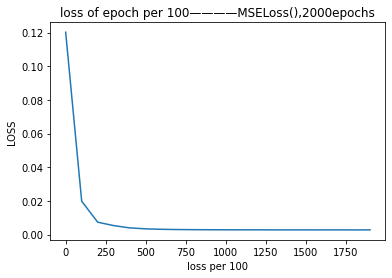

In [14]:
'''训练模型，根据训练集的前679个数据得到预测值'''
prediction = train(training_data_feature.view(training_data_feature.shape[0],1,-1), training_data_pred.view(training_data_pred.shape[0],1,-1), lstm, optimizer, loss_mse, 2000)

In [33]:
'''反向归一化，然后求得训练集自身和预测值的sMAPE值'''
train_max = np.max(train_data_rows, axis=1)  #axis=1表示求各行的最大值
train_min = np.min(train_data_rows, axis=1)

train_max_ts = torch.tensor(train_max).view(train_max.shape[0],1,-1)
train_min_ts = torch.tensor(train_min).view(train_max.shape[0],1,-1)

y = reverse_normalizationdata(training_data_pred.view(training_data_pred.shape[0],1,-1), train_max_ts, train_min_ts)
pred = reverse_normalizationdata(prediction, train_max_ts, train_min_ts)
#要改变y标签的维度与预测值的维度相匹配
sMAPE(pred, y.view(training_data_pred.shape[0],1,-1))

torch.Size([81, 1, 1])


tensor(19.8531, dtype=torch.float64, grad_fn=<MulBackward0>)